In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d salmaneunus/railway-track-fault-detection

Dataset URL: https://www.kaggle.com/datasets/salmaneunus/railway-track-fault-detection
License(s): copyright-authors
100% 1.99G/2.00G [00:29<00:00, 134MB/s]
100% 2.00G/2.00G [00:29<00:00, 72.6MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/railway-track-fault-detection.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [6]:
train_add = '/content/Railway Track fault Detection Updated/Train'
test_add = '/content/Railway Track fault Detection Updated/Test'
validation_add = '/content/Railway Track fault Detection Updated/Validation'

In [7]:
train_def = pd.DataFrame(os.listdir(train_add + '/Defective'))
train_ndef = pd.DataFrame(os.listdir(train_add + '/Non defective'))
test_def = pd.DataFrame(os.listdir(test_add + '/Defective'))
test_ndef = pd.DataFrame(os.listdir(test_add + '/Non defective'))
val_def = pd.DataFrame(os.listdir(validation_add + '/Defective'))
val_ndef = pd.DataFrame(os.listdir(validation_add + '/Non defective'))

In [8]:
print("Size of training dataset: ", len(train_def)+len(train_ndef))
print("Size of test dataset: ", len(test_def)+len(test_ndef))
print("Size of validation dataset: ", len(val_def)+len(val_ndef))

Size of training dataset:  300
Size of test dataset:  22
Size of validation dataset:  62


In [9]:
print("Train Defective count:", len(train_def))
print("Train Non defective count", len(train_ndef))
print("Test Defective count:", len(test_def))
print("Test Non defective count", len(test_ndef))
print("Validation Defective count:", len(val_def))
print("Validation Non defective count", len(val_ndef))

Train Defective count: 150
Train Non defective count 150
Test Defective count: 11
Test Non defective count 11
Validation Defective count: 31
Validation Non defective count 31


Defective data sample



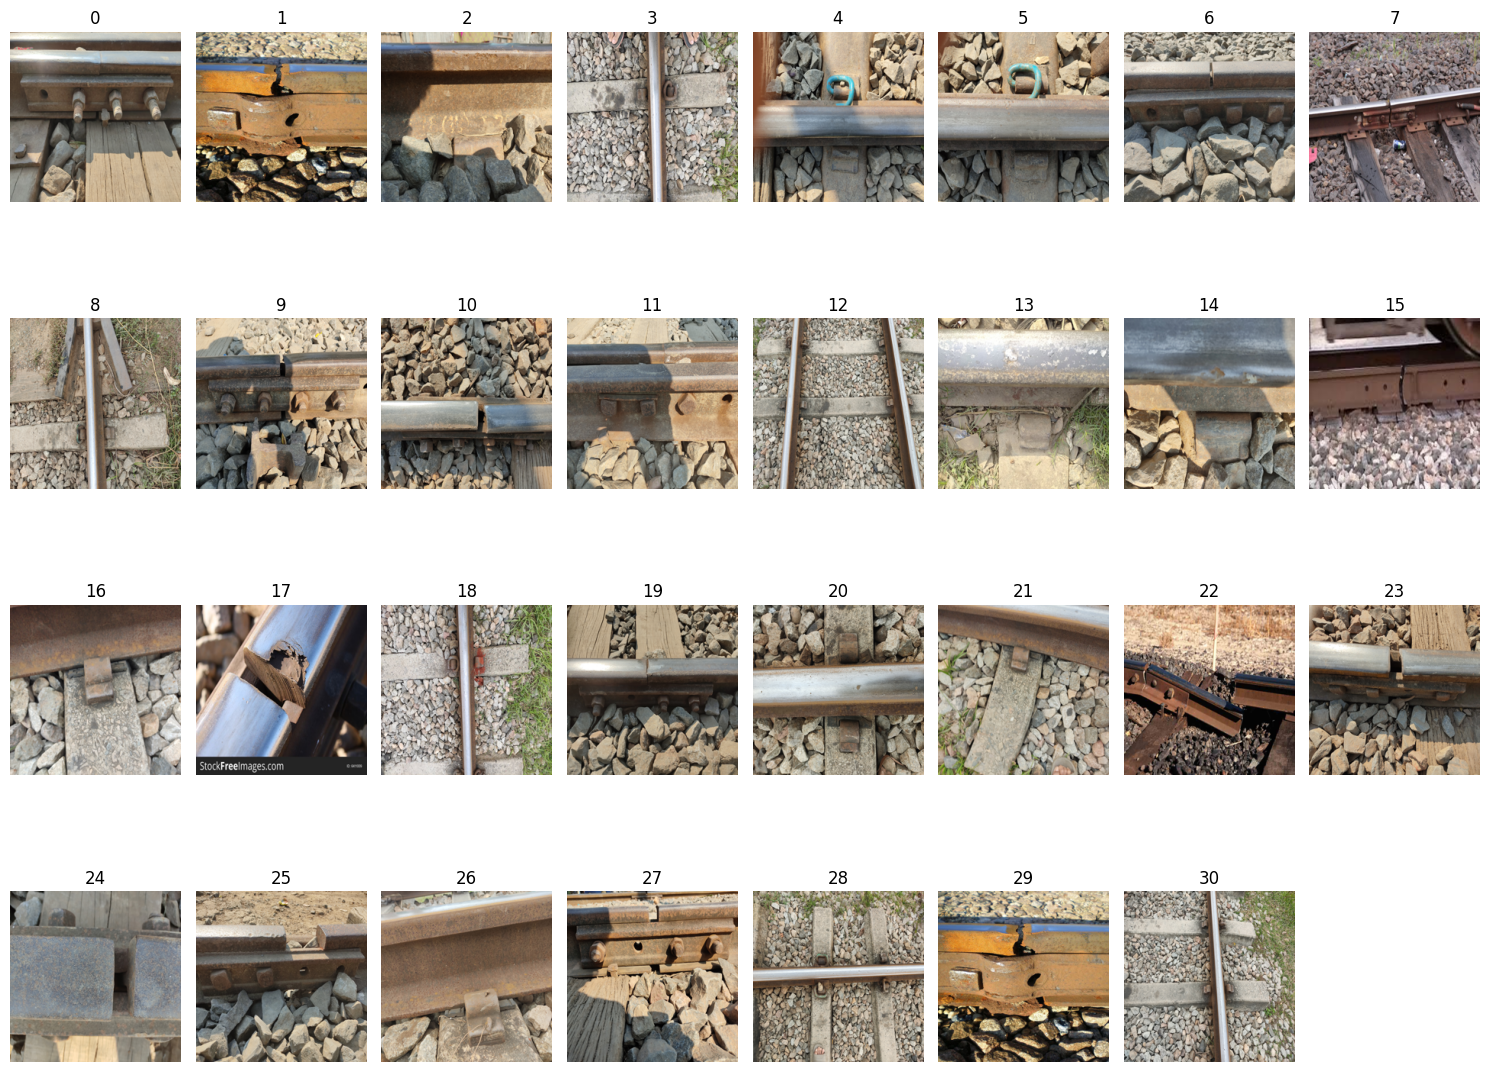

In [10]:
print("Defective data sample\n")
plt.figure(figsize = (15,12))
for idx,image_path in enumerate(train_def[0]):
    if idx==31:
        break
    plt.subplot(4,8,idx+1)
    img = Image.open('/content/Railway Track fault Detection Updated/Train/Defective/'+image_path)
    img = img.resize((224,224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(idx)
plt.tight_layout()
plt.show()

Non defective data sample



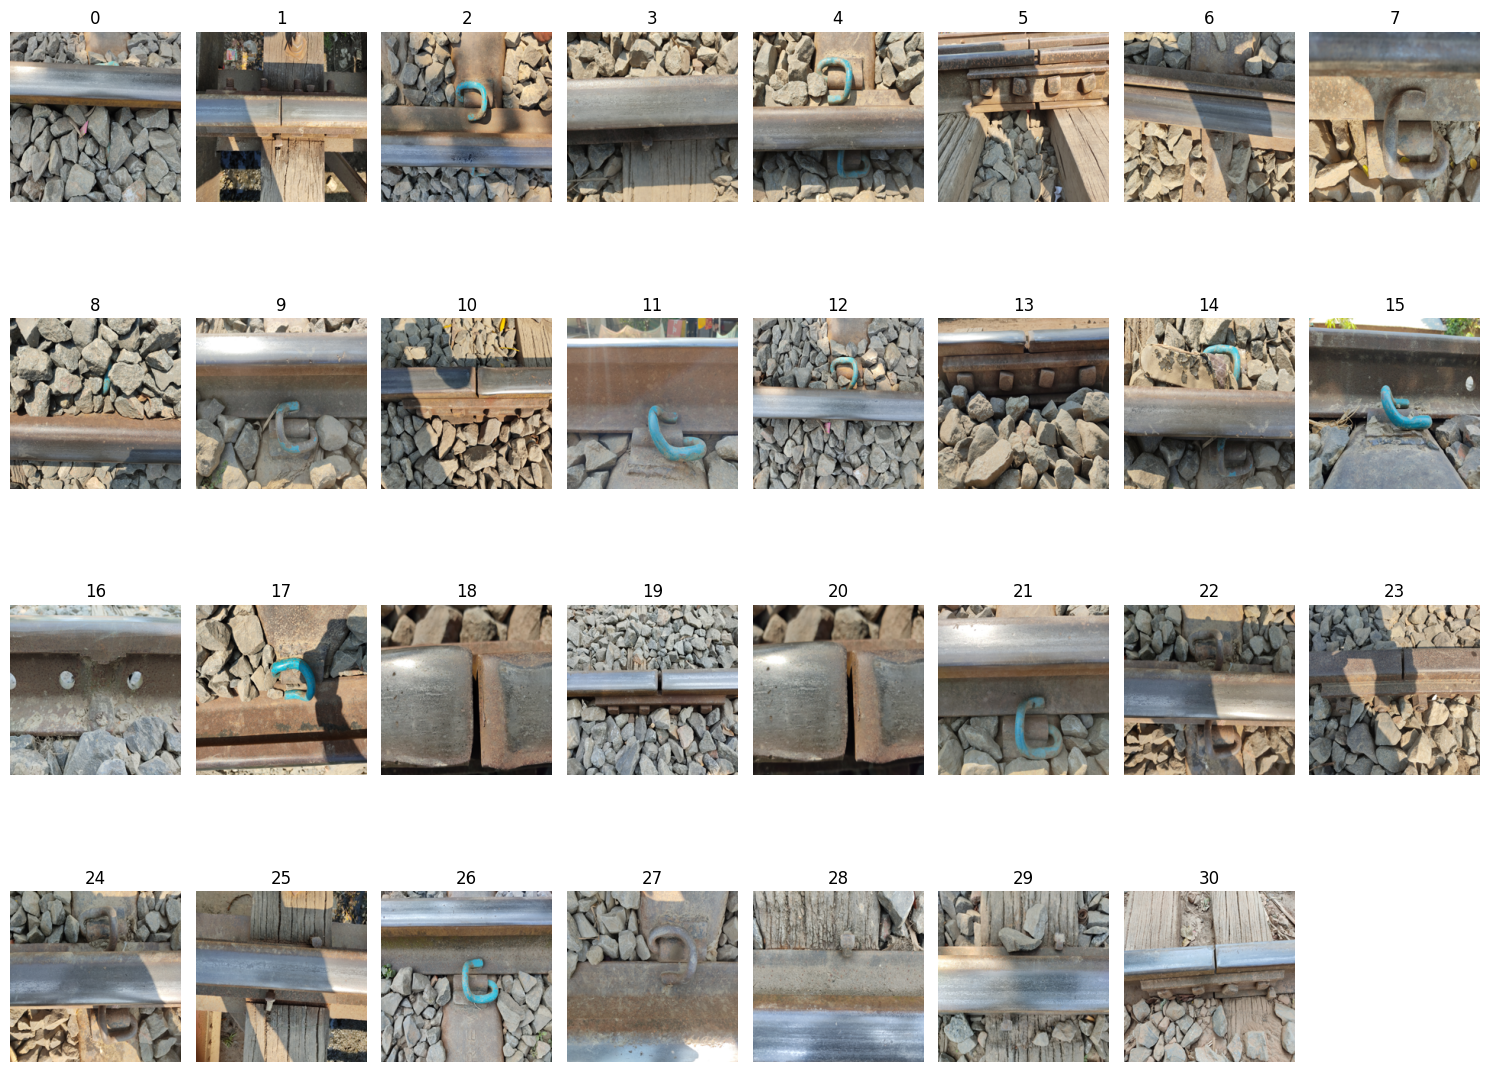

In [11]:
print("Non defective data sample\n")
plt.figure(figsize = (15,12))
for idx,image_path in enumerate(train_ndef[0]):
    if idx==31:
        break
    plt.subplot(4,8,idx+1)
    img = Image.open('/content/Railway Track fault Detection Updated/Train/Non defective/'+image_path)
    img = img.resize((224,224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(idx)
plt.tight_layout()
plt.show()

In [12]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/Railway Track fault Detection Updated/Train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/Railway Track fault Detection Updated/Validation',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

test_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/Railway Track fault Detection Updated/Test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

Found 299 files belonging to 2 classes.
Found 62 files belonging to 2 classes.
Found 22 files belonging to 2 classes.


In [13]:
def normalize(image, label):
  image = tf.cast(image/256, tf.float32)
  return image, label

In [14]:
train_ds = train_ds.map(normalize)
validation_ds = validation_ds.map(normalize)
test_ds = test_ds.map(normalize)

In [54]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [55]:
batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/Railway Track fault Detection Updated/Train',
        target_size=(256,256),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/content/Railway Track fault Detection Updated/Validation',
        target_size=(256,256),
        batch_size=batch_size,
        class_mode='binary')

Found 299 images belonging to 2 classes.
Found 62 images belonging to 2 classes.


In [98]:
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [99]:
model_vgg = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3)
)

In [100]:
model_vgg.trainable=False

for layer in model_vgg.layers:
  if layer.name == 'block5_conv1':
    layer.trainable= True
  else:
    layer.trainable = False

In [101]:
model=Sequential()
model.add(model_vgg)
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

In [102]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_16 (Flatten)        (None, 32768)             0         
                                                                 
 dense_32 (Dense)            (None, 128)               4194432   
                                                                 
 batch_normalization_18 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_33 (Dense)            (None, 1)                 129       
                                                     

In [103]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [104]:
history=model.fit_generator(train_generator, validation_data=validation_generator, epochs=15, callbacks=[early_stopping])

<ipython-input-104-c51eddab5580>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, validation_data=validation_generator, epochs=15, callbacks=[early_stopping])


Epoch 1/15
10/10 [==============================] - 52s 5s/step - loss: 0.7832 - accuracy: 0.6856 - val_loss: 0.7940 - val_accuracy: 0.7742
Epoch 2/15
10/10 [==============================] - 47s 5s/step - loss: 0.4160 - accuracy: 0.7893 - val_loss: 1.2924 - val_accuracy: 0.6290
Epoch 3/15
10/10 [==============================] - 45s 5s/step - loss: 0.3428 - accuracy: 0.8361 - val_loss: 0.5185 - val_accuracy: 0.8226
Epoch 4/15
10/10 [==============================] - 47s 5s/step - loss: 0.2512 - accuracy: 0.9197 - val_loss: 0.4299 - val_accuracy: 0.9032
Epoch 5/15
10/10 [==============================] - 45s 4s/step - loss: 0.2290 - accuracy: 0.9164 - val_loss: 0.4923 - val_accuracy: 0.8226
Epoch 6/15
10/10 [==============================] - 49s 5s/step - loss: 0.2201 - accuracy: 0.9331 - val_loss: 0.4585 - val_accuracy: 0.8226
Epoch 7/15
10/10 [==============================] - 44s 4s/step - loss: 0.1803 - accuracy: 0.9599 - val_loss: 0.3780 - val_accuracy: 0.8387
Epoch 8/15
10/10 [==

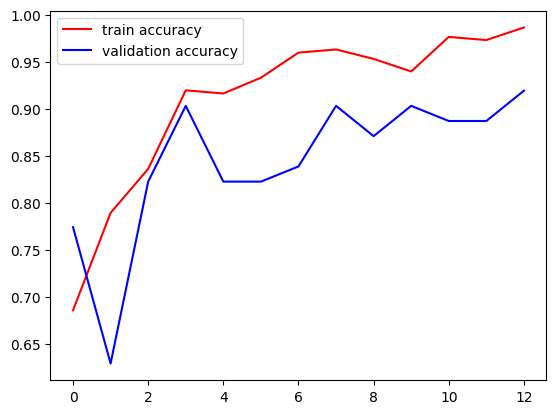

In [105]:
plt.plot(history.history['accuracy'],color='red',label='train accuracy')
plt.plot(history.history['val_accuracy'],color='blue',label='validation accuracy')
plt.legend()
plt.show()

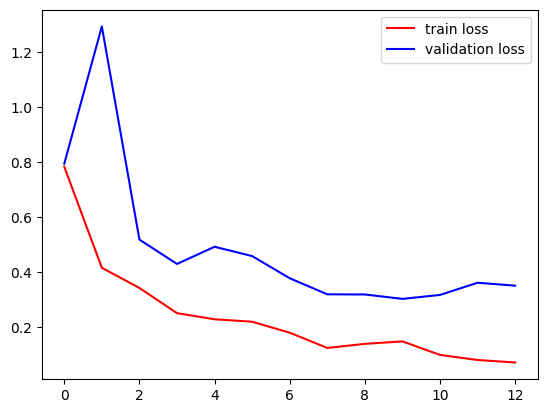

In [106]:
plt.plot(history.history['loss'],color='red',label='train loss')
plt.plot(history.history['val_loss'],color='blue',label='validation loss')
plt.legend()
plt.show()

In [107]:
model.evaluate(test_ds)

1/1 [==============================] - 2s 2s/step - loss: 0.2417 - accuracy: 0.8636


[0.24170832335948944, 0.8636363744735718]